In [20]:
from PIL import Image
import torch
import numpy as np
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import TexturesAtlas
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader
)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

obj_path = "/cluster/scratch/aarslan/FFHQ/mesh_and_texture/00009.obj"

verts, faces, aux = load_obj(obj_path, create_texture_atlas=True)
atlas = torch.tensor(aux.texture_atlas, requires_grad=True, device=device)
tex = TexturesAtlas(atlas=[atlas])
mesh = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex)

# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
# R, T = look_at_view_transform(0.7, 0.0, 70.0)
R, T = look_at_view_transform(dist=0.70, elev=0, azim=60.0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, # 1024
    blur_radius=0.0, 
    faces_per_pixel=1 # 5
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
image = images[0, :, :, :3]
# plt.figure(figsize=(10, 10))
# plt.imshow(images[0, ..., :3].detach().cpu().numpy())
# plt.axis("off");

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/cluster/scratch/aarslan/miniconda3/envs/face_sde/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/cluster/scratch/aarslan/miniconda3/envs/face_sde/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/scratch/219176032.tmpdir/ipykernel_54001/621070072.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  atlas = torch.tensor(aux.texture_atlas, requires_grad=True, device=device)


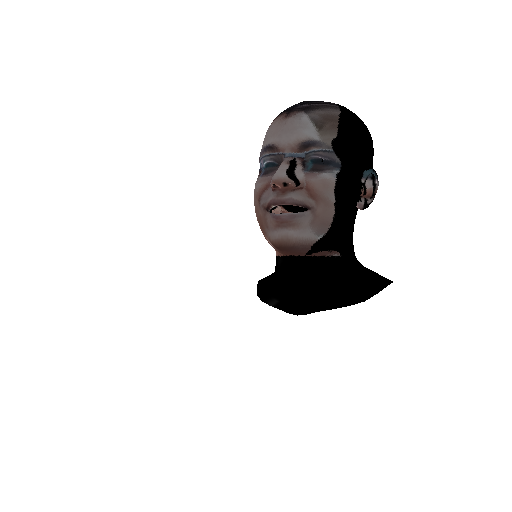

In [21]:
Image.fromarray((image.detach().cpu().numpy() * 255).astype(np.uint8))

In [ ]:
# train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=False, evaluation=True)
# eval_batch = next(iter(eval_ds))
# eval_images = eval_batch['image']._numpy()
# shape = (batch_size, 3, 32, 32)



likelihood_fn = likelihood.get_likelihood_fn(sde, inverse_scaler, eps=1e-5)
sampling_fn = sampling.get_ode_sampler(sde, shape, inverse_scaler,
                                       denoise=True, eps=sampling_eps, device=config.device)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_grid(eval_images))
plt.title('Original images')

eval_images = torch.from_numpy(eval_images).permute(0, 3, 1, 2).to(config.device)
_, latent_z, _ = likelihood_fn(score_model, scaler(eval_images))

x, nfe = sampling_fn(score_model, latent_z)

x = x.permute(0, 2, 3, 1).cpu().numpy()
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_grid(x))
plt.title('Reconstructed images')

In [1]:
import os
import sys
import torch
import pytorch3d


/cluster/scratch/aarslan/miniconda3/envs/face_sde/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.renderer.mesh import TexturesAtlas

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [3]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

In [4]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

obj_path = "/cluster/scratch/aarslan/FFHQ/mesh_and_texture/00000.obj"

verts, faces, aux = load_obj(obj_path, create_texture_atlas=True)
atlas = torch.tensor(aux.texture_atlas, requires_grad=True, device=device)
tex = TexturesAtlas(atlas=[atlas])

mesh = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex)

# verts_rgb_colors = get_verts_rgb_colors(obj_path)
# verts_rgb_colors = torch.from_numpy(verts_rgb_colors).to(device)
# textures = TexturesVertex(verts_features=verts_rgb_colors)
# # wo_textures = TexturesVertex(verts_features=torch.ones_like(verts_rgb_colors)*0.75)

# # Load obj
# mesh = load_objs_as_meshes([obj_path], device=device)

# # Set mesh
# verts = mesh._verts_list
# faces = mesh._faces_list
# mesh = Meshes(verts, faces, textures)


# verts, faces, aux = load_obj(obj_filename)

# # Load obj file
# verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
# faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)
# tex_maps = aux.texture_images

# # tex_maps is a dictionary of {material name: texture image}.
# # Take the first image:
# texture_image = list(tex_maps.values())[0]
# texture_image = texture_image[None, ...]  # (1, H, W, 3)
# # texture_image = torch.tensor(texture_image, requires_grad=True)

# # Create a textures object
# # tex = TexturesUV(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)
# tex = TexturesVertex(verts)

# # tex.maps_list()[0].requires_grad = True

# # Initialise the mesh with textures
# mesh = Meshes(verts=[verts], faces=[faces.verts_idx], textures=tex)

# mesh = load_objs_as_meshes([obj_filename], device=device)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/cluster/scratch/aarslan/miniconda3/envs/face_sde/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/cluster/scratch/aarslan/miniconda3/envs/face_sde/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/cluster/scratch/aarslan/miniconda3/envs/face_sde/lib/python3.9/site-packages/pytorch3d/io/utils.py:66: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
/scratch/219112470.tmpdir/ipykernel_32740/2001459388.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  atlas = torch.tensor(aux.texture_atlas, requires_grad=True, device=device)


In [5]:
plt.figure(figsize=(7, 7))
texture_image=mesh.textures.atlas_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 504x504 with 0 Axes>

In [6]:
mesh.textures.maps_list()[0].shape

torch.Size([1024, 1024, 3])

In [7]:
mesh.textures.maps_padded()[0] is mesh.textures.maps_list()[0]

False

In [6]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(0.58, 0, 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, # 1024
    blur_radius=0.0, 
    faces_per_pixel=1 # 5
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

torch.Size([1, 256, 256, 4])

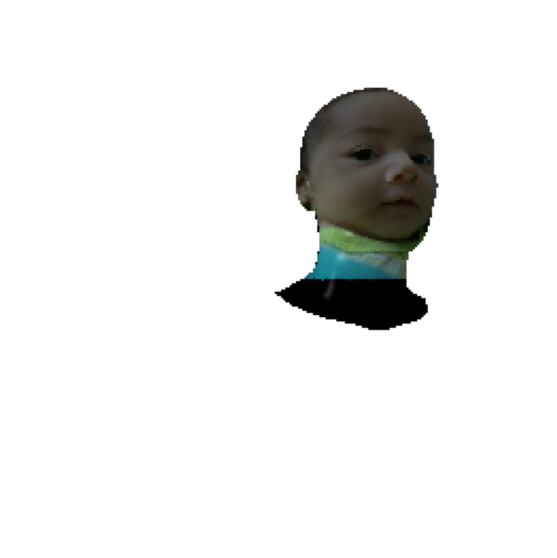

In [8]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.axis("off");